In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

from IPython.display import clear_output

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})



In [2]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_diabetes

diab = load_diabetes()
diab["data"].shape

(442, 10)

In [3]:
print(diab["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [4]:
diab["target"].max()

346.0

In [5]:
np.column_stack([diab["data"], diab["target"]]).shape

(442, 11)

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device

device(type='mps')

In [7]:
load_iris()["data"][load_iris()["target"] == 1].shape

(50, 4)

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
MinMaxScaler().fit_transform(load_diabetes()["data"])

array([[0.66666667, 1.        , 0.58264463, ..., 0.28208745, 0.562217  ,
        0.43939394],
       [0.48333333, 0.        , 0.14876033, ..., 0.14104372, 0.22243673,
        0.16666667],
       [0.88333333, 1.        , 0.51652893, ..., 0.28208745, 0.49657763,
        0.40909091],
       ...,
       [0.68333333, 1.        , 0.28512397, ..., 0.24964739, 0.30503001,
        0.56060606],
       [0.28333333, 0.        , 0.49586777, ..., 0.39351199, 0.65702552,
        0.40909091],
       [0.28333333, 0.        , 0.0661157 , ..., 0.14104372, 0.46930394,
        0.51515152]])

In [90]:
# Custom Dataset for Tabular Data
class TabularDataset(Dataset):
    def __init__(self, file_path):
        if file_path == "IRIS":
            # self.data = load_iris()["data"]
            self.data = load_iris()["data"][load_iris()["target"] == 2]
        if file_path == "DIAB":
            self.data = load_diabetes()["data"]
            # self.data = MinMaxScaler().fit_transform(load_diabetes()["data"])
            self.data /= np.abs(self.data.max())
        if file_path == "NORMAL":
            self.data = torch.normal(5,5, (1000, 2))
            self.data = MinMaxScaler().fit_transform(self.data)
        else:
            self.data = pd.read_csv(file_path)
        # self.data = (self.data - self.data.mean()) / self.data.std()  # Normalize
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32)
        return sample, torch.tensor(0)

def get_dataloader(file_path, batch_size=64):
    dataset = TabularDataset(file_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


In [91]:
# loader = get_dataloader("IRIS", batch_size=32)
# loader = get_dataloader("DIAB", batch_size=32)
loader = get_dataloader("NORMAL", batch_size=32)


# for i in loader:
#     print(i[0])
#     break


### Generator model

In [80]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            # nn.BatchNorm1d(128),
            nn.Linear(128, output_dim),
            # nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z)

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.ReLU(True),
            nn.Linear(128, output_dim)
        )

    def forward(self, input):
        return self.main(input)


### Discriminator model

In [81]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.ReLU(True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


### Training loop

In [82]:
def plot_losses(generator_losses, discriminator_losses):
    """
    Plot loss and perplexity of train and validation samples
    :param train_losses: list of train losses at each epoch
    :param val_losses: list of validation losses at each epoch
    """
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(generator_losses) + 1), generator_losses)
    axs[0].set_ylabel('loss')
    axs[0].set_title("Generator loss")

    axs[1].plot(range(1, len(discriminator_losses) + 1), discriminator_losses)
    axs[1].set_ylabel('loss')
    axs[1].set_title("Discriminator loss")

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()


In [83]:
def train_gan(
        generator,
        discriminator,
        dataloader,
        num_epochs=100,
        latent_dim=100,
        lr_generator=0.0002,
        lr_discriminator=0.0002,
        device='cuda',
    ):

    generator.to(device)
    discriminator.to(device)
    
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=lr_generator, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(0.5, 0.999))

    generator_loss_hist = []
    discriminator_loss_hist = []
    
    for epoch in tqdm(range(num_epochs)):
        for real_data, _ in dataloader:
            real_data = real_data.to(device)
            batch_size = real_data.size(0)

            # Create labels
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            
            # ---- Train Discriminator ----
            optimizer_D.zero_grad()
            
            # Real data loss
            real_preds = discriminator(real_data)
            loss_real = criterion(real_preds, real_labels)
            
            # Fake data loss
            z = torch.normal(0,2, (batch_size, latent_dim)).to(device)
            fake_data = generator(z)
            fake_preds = discriminator(fake_data.detach())  # Detach to avoid updating G
            loss_fake = criterion(fake_preds, fake_labels)
            
            # Total discriminator loss
            loss_D = (loss_real + loss_fake) / 2
            loss_D.backward()
            optimizer_D.step()
            
            # ---- Train Generator ----
            optimizer_G.zero_grad()
            
            # Generate fake data
            fake_preds = discriminator(fake_data)  # Re-evaluate fake data
            loss_G = criterion(fake_preds, real_labels)  # Trick D into thinking it's real
            
            loss_G.backward()
            optimizer_G.step()
        
        generator_loss_hist.append(loss_G.item())
        discriminator_loss_hist.append(loss_D.item())

        if epoch % 50 == 0:

            plot_losses(generator_loss_hist, discriminator_loss_hist)

            with torch.no_grad():
                z = torch.normal(0,2, (1, 100)).to(device)
                fake_data = generator(z)

                print("GEN example:", fake_data)
    
    print("Training Complete!")


### Training loop

In [18]:
torch.normal(1,2, (3,3))

tensor([[-0.7379,  0.8542,  1.8811],
        [ 3.0761,  0.4913, -1.8352],
        [-2.9826, -1.9888, -0.6959]])

In [19]:
for i in loader:
    print(i[0].shape)

torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([26, 10])


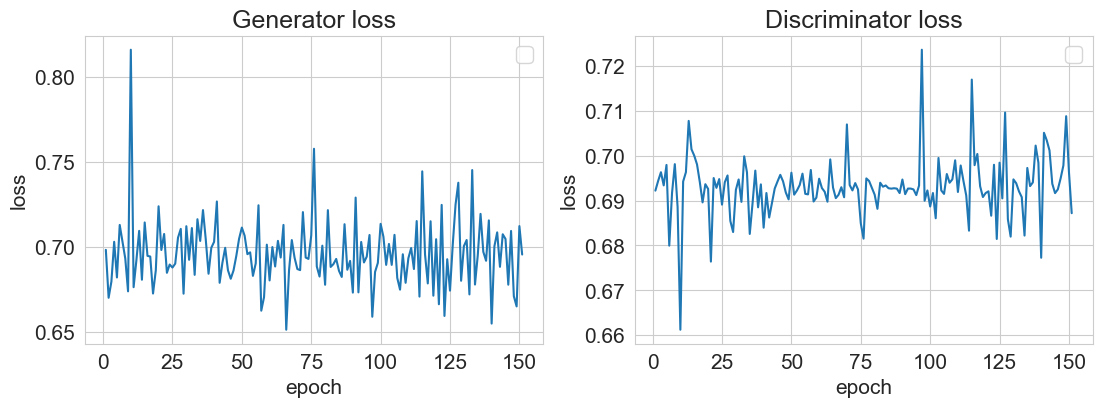

 15%|█▌        | 152/1001 [00:23<02:32,  5.56it/s]

GEN example: tensor([[0.4801, 0.3759]], device='mps:0')


 16%|█▋        | 164/1001 [00:25<02:08,  6.51it/s]


KeyboardInterrupt: 

In [92]:
params = {
    "latent_dim": 100,
    "lr_generator": 0.001,
    "lr_discriminator": 0.001
}

generator = Generator(input_dim=params["latent_dim"], output_dim=2)
discriminator = Discriminator(input_dim=2)

train_gan(
    generator=generator,
    discriminator=discriminator,
    dataloader=loader,
    latent_dim=params["latent_dim"],

    lr_discriminator=params["lr_discriminator"],
    lr_generator=params["lr_generator"],
    
    num_epochs=1001,
    device=device,
)

In [53]:
with torch.no_grad():
    z = torch.normal(0,2, (1, 100)).to(device)
    fake_data = generator(z)

    print(fake_data)

tensor([[ 268.4599,  417.8869,  539.7533,  666.8936,  412.4876, -363.9714,
          -87.8168,  249.8577,  606.9520, -258.6818]], device='mps:0')


In [309]:
for i in loader:
    print(i[0][:5,:])
    break

tensor([[ 3.0811e-02,  5.0680e-02,  3.2595e-02,  4.9415e-02, -4.0096e-02,
         -4.3589e-02, -6.9172e-02,  3.4309e-02,  6.3015e-02,  3.0644e-03,
          2.0800e+02],
        [ 1.7505e-03,  5.0680e-02,  1.1039e-02, -1.9442e-02, -1.6704e-02,
         -3.8191e-03, -4.7082e-02,  3.4309e-02,  2.4055e-02,  2.3775e-02,
          1.1100e+02],
        [ 4.8974e-02,  5.0680e-02,  7.4630e-02,  6.6629e-02, -9.8247e-03,
         -2.2533e-03, -4.3401e-02,  3.4309e-02,  3.3654e-02,  1.9633e-02,
          2.7500e+02],
        [ 8.8931e-02, -4.4642e-02,  6.7278e-03,  2.5315e-02,  3.0078e-02,
          8.7069e-03,  6.3367e-02, -3.9493e-02,  9.4337e-03,  3.2059e-02,
          1.0900e+02],
        [-3.4575e-02,  5.0680e-02, -2.5607e-02, -1.7135e-02,  1.1829e-03,
         -2.8796e-03,  8.1421e-03, -1.5508e-02,  1.4821e-02,  4.0343e-02,
          7.4000e+01]])


### Visualize

In [54]:

def tsne_plot(x1, y1):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(8, 4))
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Real')
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Generated')

    plt.legend(loc='best')
    plt.show()
    

In [56]:
real_data = None
gen_data = None

for i in loader:
    if real_data is None:
        real_data = i[0]
    else:
        real_data = torch.cat([real_data, i[0]])

for _ in range(100):
    z = torch.normal(0,2, (1, 100)).to(device)
    # print(z.shape)
    fake_data = generator(z)

    if gen_data is None:
        gen_data = fake_data
    else:
        gen_data = torch.cat([gen_data, fake_data])
gen_data = gen_data.detach().to("cpu")

/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_56668/3193453362.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(self.data[idx], dtype=torch.float32)


In [57]:
real_data.shape, gen_data.shape

(torch.Size([1000, 10]), torch.Size([100, 10]))

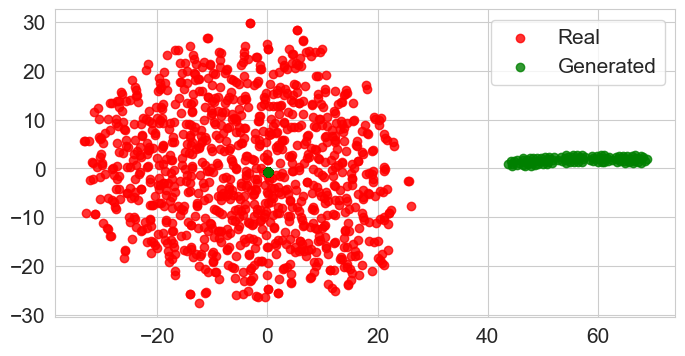

In [58]:
gen_data1 = torch.zeros((0,11))
real_data1 = torch.zeros((0,11))

tsne_plot(
    np.array(torch.cat([real_data, gen_data])),
    torch.cat(  [torch.ones((real_data.shape[0],1)), torch.zeros((gen_data.shape[0],1))]  )
)

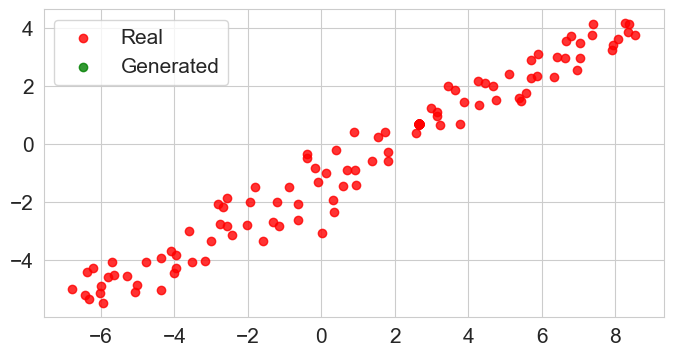

In [ ]:
tsne_plot(
    gen_data,
    torch.ones((gen_data.shape[0],1))
)

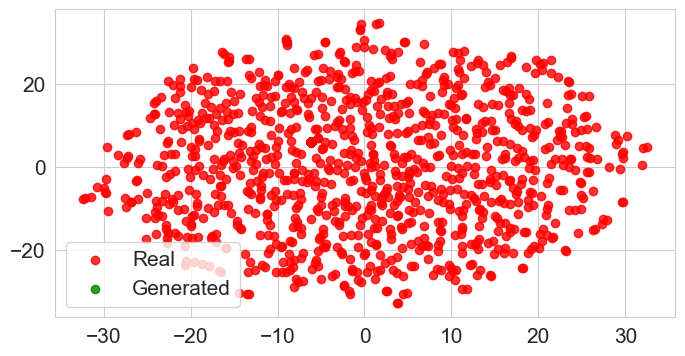

In [32]:
tsne_plot(
    real_data,
    torch.ones((real_data.shape[0],1))
)